In [ ]:
import math
import matplotlib.pyplot as plt
from hypergrammar.hypergraph import Hypergraph
from hypergrammar.edge import Edge, EdgeType
from hypergrammar.productions.prod_7 import Prod7

# Setup Enums and Monkeypatching
if not hasattr(EdgeType, 'P'):
    try:
        import aenum
        aenum.extend_enum(EdgeType, 'P', 99)
    except ImportError: pass

def edge_str_with_params(self):
    # Custom label: Shows R parameter clearly
    r_val = self.parameters.get("R")
    label = self.edge_type.name
    if r_val is not None:
        label += f"\nR={r_val}"
    return label
Edge.__str__ = edge_str_with_params

# Function to create a Pentagon Hypergraph 
def create_pentagon_hg(p_r_val=1, break_topology=False):
    hg = Hypergraph()
    verts = ["v1", "v2", "v3", "v4", "v5"]
    
    # 1. Geometry (Coordinates)
    center = (2.5, 2.5); radius = 2.0
    for i, v in enumerate(verts):
        angle_rad = math.radians(90 + i * 72)
        hg.set_vertex_parameter(v, {
            "x": center[0] + radius * math.cos(angle_rad),
            "y": center[1] + radius * math.sin(angle_rad)
        })

    # 2. Boundary Edges (Type E)
    # If break_topology is True, we skip the last edge to break the cycle
    pairs = [("v1", "v2"), ("v2", "v3"), ("v3", "v4"), ("v4", "v5"), ("v5", "v1")]
    if break_topology:
        pairs.pop() # Remove v5-v1
        
    for v1, v2 in pairs:
        hg.add_edge(Edge(EdgeType.E, frozenset({v1, v2}), {"R": 0, "B": 1}))

    # 3. Central Edge (Type P)
    hg.add_edge(Edge(EdgeType.P, frozenset(verts), {"R": p_r_val}))
    
    return hg



TEST 1: Valid Application
Production applied successfully.


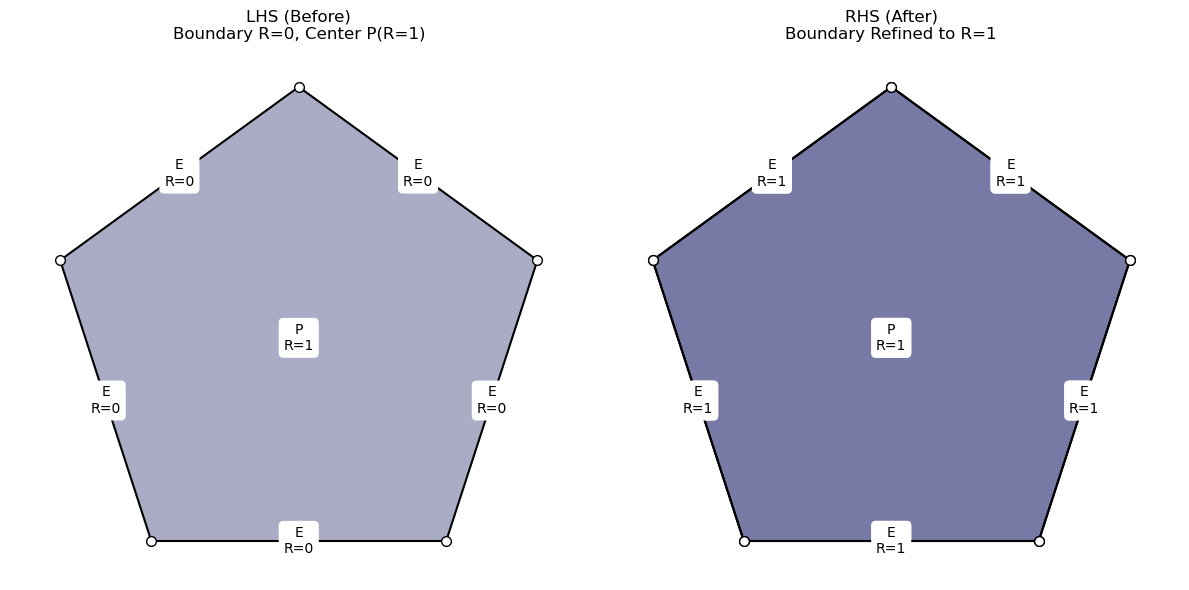

In [11]:

print("\nTEST 1: Valid Application")
hg_valid = create_pentagon_hg(p_r_val=1) # Correct R=1

# Apply Production
prod7 = Prod7()
result_valid = prod7.apply(hg_valid)

# Plotting Side-by-Side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title("LHS (Before)\nBoundary R=0, Center P(R=1)")
hg_valid.draw(use_positional_parameters=True) 

plt.sca(axes[0]) # Set current axis to left
hg_valid.draw(use_positional_parameters=True)

if result_valid:
    plt.sca(axes[1]) # Set current axis to right
    axes[1].set_title("RHS (After)\nBoundary Refined to R=1")
    result_valid.draw(use_positional_parameters=True)
    print("Production applied successfully.")
else:
    print("Production failed unexpectedy.")
    
plt.tight_layout()
plt.show()


 TEST 2: Negative Case (Wrong R Value)
Correctly rejected graph with R=0.


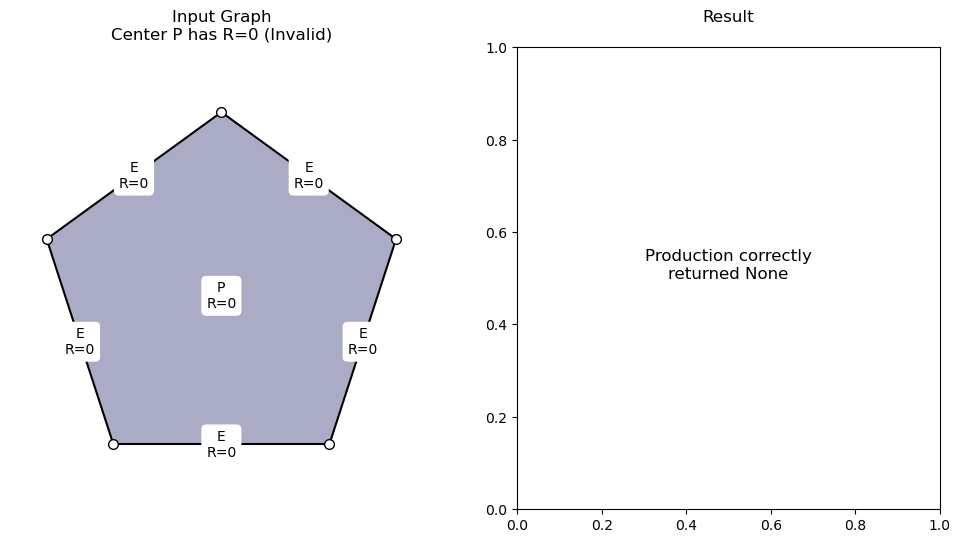

In [12]:
print("\n TEST 2: Negative Case (Wrong R Value)")
hg_wrong_r = create_pentagon_hg(p_r_val=0) # Incorrect R=0

result_wrong_r = prod7.apply(hg_wrong_r)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.sca(axes[0])
axes[0].set_title("Input Graph\nCenter P has R=0 (Invalid)")
hg_wrong_r.draw(use_positional_parameters=True)

plt.sca(axes[1])
axes[1].set_title("Result\n")
if result_wrong_r is None:
    axes[1].text(0.5, 0.5, "Production correctly\nreturned None", ha='center', fontsize=12)
    print("Correctly rejected graph with R=0.")
else:
    result_wrong_r.draw(use_positional_parameters=True)
    print("Error: Production applied when it should not have.")
    
plt.show()


TEST 3: Negative Case (Broken Cycle)
Correctly rejected graph with broken cycle.


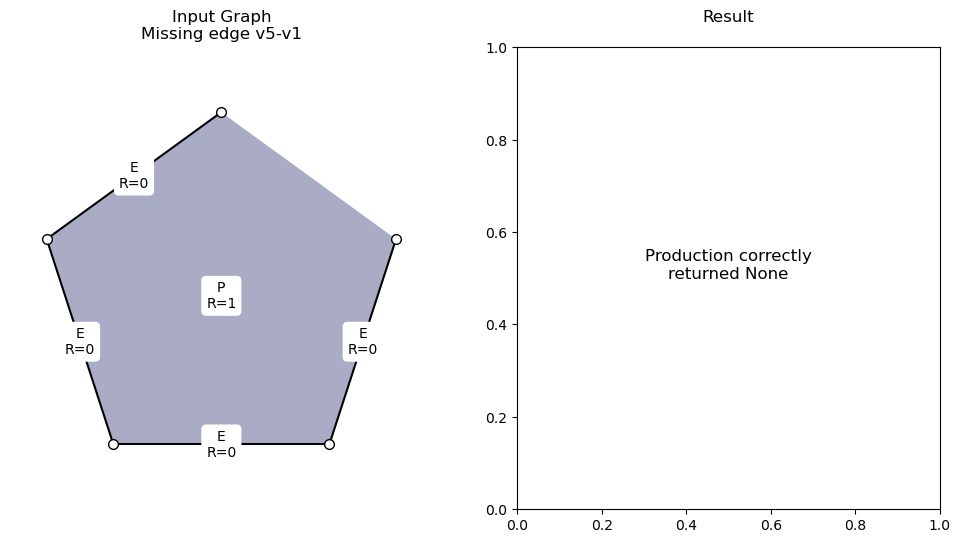

In [13]:
print("\nTEST 3: Negative Case (Broken Cycle)")
hg_broken = create_pentagon_hg(p_r_val=1, break_topology=True) # Missing one edge

result_broken = prod7.apply(hg_broken)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.sca(axes[0])
axes[0].set_title("Input Graph\nMissing edge v5-v1")
hg_broken.draw(use_positional_parameters=True)

plt.sca(axes[1])
axes[1].set_title("Result\n")
if result_broken is None:
    axes[1].text(0.5, 0.5, "Production correctly\nreturned None", ha='center', fontsize=12)
    print("Correctly rejected graph with broken cycle.")
else:
    result_broken.draw(use_positional_parameters=True)
    print("Error: Production applied to broken topology.")

plt.show()